In [61]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

### Генерациия датасета

In [62]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

Посмотрим на сгенерированные данные 

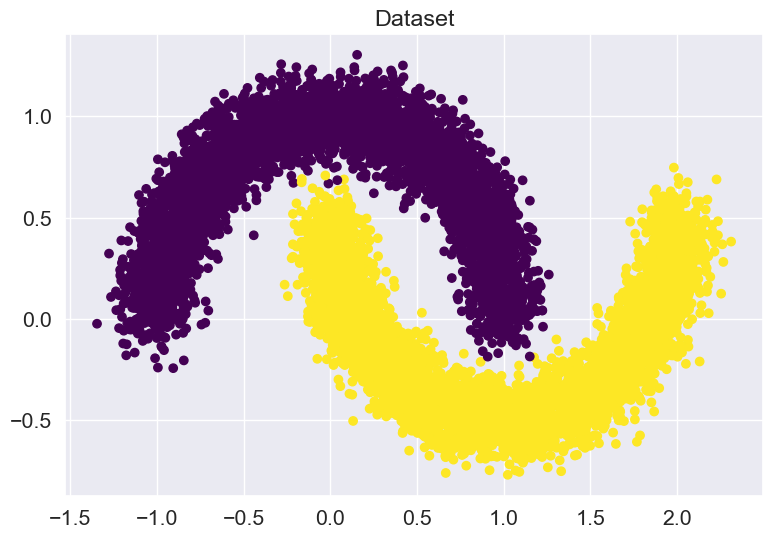

In [63]:
plt.figure(figsize=(9, 6))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")

plt.show()

Разделим выборку на тренировочную и тестовую

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Работа с torch

Создадим объект класса DataLoader

In [65]:
X_train_t = torch.clone(torch.from_numpy(X_train)).type(torch.float32)
y_train_t = torch.clone(torch.from_numpy(y_train)).type(torch.float32)
X_test_t = torch.clone(torch.from_numpy(X_test)).type(torch.float32)
y_test_t = torch.clone(torch.from_numpy(y_test)).type(torch.float32)

In [66]:
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=64)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64)

In [80]:
len(train_dataloader)

110

Реализуем логистическую регрессию

In [76]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(1))

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x +=  self.bias_term
        return x

In [82]:
linear_regression = LinearRegression(in_features=2, out_features=1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

Посмотрим на количество обучаемых параметров регрессии

In [83]:
training_params_count = sum(params_tensor.numel() for params_tensor in linear_regression.parameters() if  params_tensor.requires_grad)
training_params_count

3

Реализуем цикл обучения модели

In [84]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        loss =  loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) 
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            print(f"Batch accuracy: {batch_acc}")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.4375
Iteration: 100
Batch accuracy: 0.84375
Iteration: 200
Batch accuracy: 0.890625
Iteration: 300
Batch accuracy: 0.84375
Iteration: 400
Batch accuracy: 0.859375
Iteration: 500
Batch accuracy: 0.90625

Iteration: 535.Convergence. Stopping iterations.
Batch accuracy: 0.78125


Видно, что на 535 итерации градиенты весов сильно затухли, т.е. можно считать, что алгоритм сошелся

Визуализируем результаты

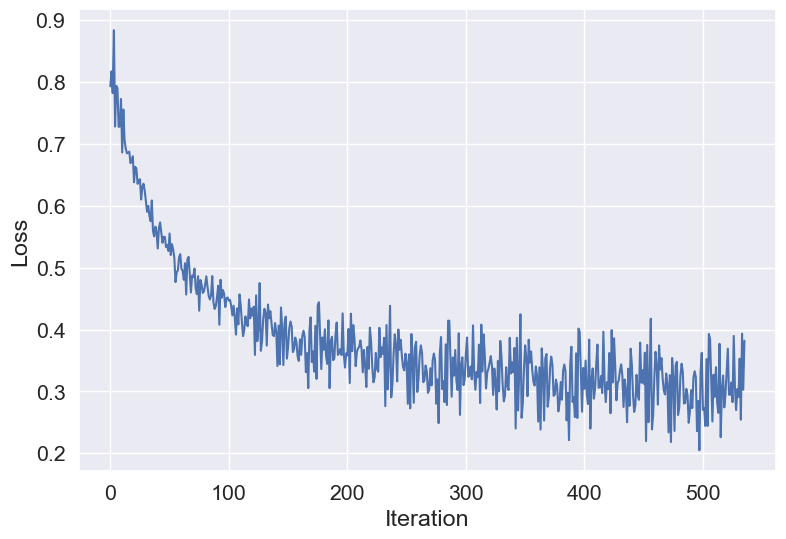

In [86]:
plt.figure(figsize=(9, 6))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

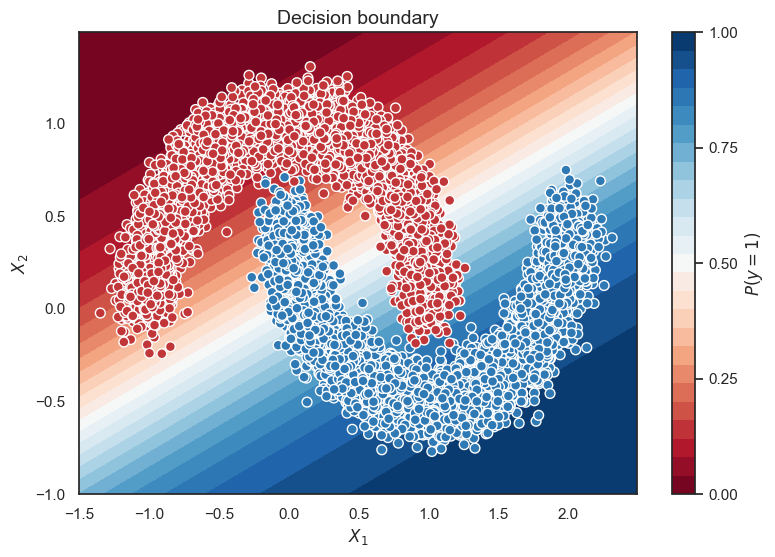

In [88]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(9, 6))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

Реализуем функцию predict

In [99]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [100]:
from sklearn.metrics import accuracy_score


In [101]:
predictions = predict(test_dataloader, linear_regression)
accuracy = accuracy_score(predictions, y_test_t)
print(f"Test accuracy: {accuracy}")

Test accuracy: 0.8673333333333333


### Датасет MNIST

In [102]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

In [ ]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
test_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)


In [105]:
batch_size = 128

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [111]:
x_batch, y_batch = next(iter(train_dataloader))
x_batch.shape, y_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

Полносвязная сеть

In [132]:
in_features = 28 * 28
out_classes = 10

activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=in_features, out_features=128),
    activation(),
    nn.Linear(in_features=128, out_features=128),
    activation(),
    nn.Linear(in_features=128, out_features=out_classes)
)

In [133]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "test": test_dataloader}

In [134]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Реализуем цикл обучения модели 

In [135]:
max_epochs = 5
accuracy = {"train": [], "test": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  torch.sum(y_batch == preds)
            all =  y_batch.size(dim=0)
            epoch_correct += correct.item()
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.87985
Loader: test. Accuracy: 0.926
Epoch: 2
Loader: train. Accuracy: 0.9429333333333333
Loader: test. Accuracy: 0.9474
Epoch: 3
Loader: train. Accuracy: 0.9588666666666666
Loader: test. Accuracy: 0.9541
Epoch: 4
Loader: train. Accuracy: 0.9682166666666666
Loader: test. Accuracy: 0.966
Epoch: 5
Loader: train. Accuracy: 0.9738333333333333
Loader: test. Accuracy: 0.9705


Протестируем другие функции активации

In [136]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [142]:
def test_activation_function(activation, loaders=loaders, criterion=criterion, optimizer=optimizer):
  in_features = 28 * 28
  out_classes = 10
  
  model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=in_features, out_features=128),
      activation(),
      nn.Linear(in_features=128, out_features=128),
      activation(),
      nn.Linear(in_features=128, out_features=out_classes)
  )

  max_epochs = 5
  accuracy = {"train": [], "test": []}
  for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
          epoch_correct = 0
          epoch_all = 0
          for x_batch, y_batch in dataloader:
              x_batch = x_batch.to(device)
              y_batch = y_batch.to(device)
              if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
              else:
                model.eval()
                outp = model(x_batch)
              preds = outp.argmax(-1)
              correct =  torch.sum(y_batch == preds)
              all =  y_batch.size(dim=0)
              epoch_correct += correct.item()
              epoch_all += all
          accuracy[k].append(epoch_correct/epoch_all)
  
  return accuracy["test"]

In [138]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)
elu_accuracy = accuracy["test"]

Построим графики accuracy для каждой функции активации

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(9, 6))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

### Реализация LeNet

In [143]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [144]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": test_dataloader}

Воспользуемся раннее написанным циклом обучения

In [ ]:
max_epochs = 5
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
              loss = criterion(outp, y_batch)
              loss.backward()
              optimizer.step()
            else:
              model.eval()
              outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  torch.sum(y_batch == preds)
            all =  y_batch.size(dim=0)
            epoch_correct += correct.item()
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)